In [1]:
import ceviche_challenges
from ceviche_challenges import units as u
from ceviche_challenges.model_base import _wavelengths_nm_to_omegas

from ceviche import viz, fdfd_ez
from ceviche import jacobian

import autograd
import autograd.numpy as npa

import numpy as np
import matplotlib.pyplot as plt

# Define the problem using ceviche_challenges

In [2]:
spec = ceviche_challenges.waveguide_bend.prefabs.waveguide_bend_2umx2um_spec(
    wg_width=400*u.nm, variable_region_size=(1600*u.nm, 1600*u.nm), cladding_permittivity=2.25
)
params = ceviche_challenges.waveguide_bend.prefabs.waveguide_bend_sim_params(resolution = 25 * u.nm)
model = ceviche_challenges.waveguide_bend.model.WaveguideBendModel(params, spec)

### Test a simple simulation

In [3]:
# The model class provides a convenience property, `design_variable_shape
# which specifies the design shape it expects.
design = np.ones(model.design_variable_shape)


# The model class has a `simulate()` method which takes the design variable as
# an input and returns scattering parameters and fields.
s_params, fields = model.simulate(design)

/home/lucas/micromamba/envs/mamba_inverse_design/lib/python3.11/site-packages/ceviche/viz.py:17: UserWarning: No contour levels were found within the data range.
  ax.contour(outline.T, 0, colors='k', alpha=outline_alpha)


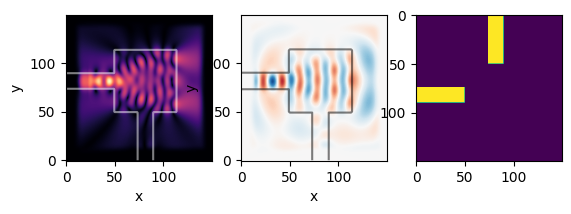

In [4]:
fig, ax = plt.subplots(1, 3)
viz.abs(fields.squeeze(), outline=model.density(np.asarray(design)), ax=ax[0]);
viz.real(fields.squeeze(), outline=model.density(np.asarray(design)), ax=ax[1]);
ax[2].imshow(model.epsilon_r_bg());

# 1) Take a look on the adjoint result with the fields

In [5]:
def mode_overlap(E1, E2):
    """Defines an overlap integral between the sim field and desired field
    """
    return npa.abs(npa.sum(npa.conj(E1)*E2))

source = model.ports[0].source_fdfd(_wavelengths_nm_to_omegas(u.resolve(params.wavelengths[0], 1*u.nm)),
                                    model.dl,#params.resolution,
                                    model.epsilon_r_bg()
                                  )
probe = model.ports[1].source_fdfd(_wavelengths_nm_to_omegas(u.resolve(params.wavelengths[0], 1*u.nm)),
                                   model.dl,#params.resolution,
                                   model.epsilon_r_bg()
                                  )

_, Ez = model.simulate(design)
E0 = mode_overlap(Ez, probe)

In [6]:
def objective(rho):
    _, Ez = model.simulate(rho)
    return mode_overlap(Ez, probe) / E0

objective(design)

1.0000000000000266

In [7]:
objective_jac = jacobian(objective, mode='reverse')

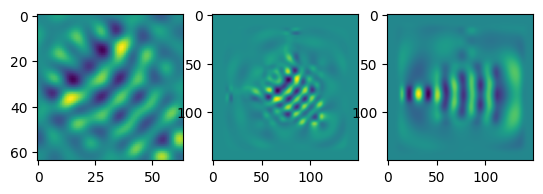

In [8]:
_, Ez_source = model.simulate(design)
_, Ez_probe = model.simulate(design, excite_port_idxs=[1])

fig, ax = plt.subplots(1,3)
ax[0].imshow(objective_jac(design).reshape(design.shape).T);
ax[1].imshow(np.real(Ez_source.squeeze() * Ez_probe.squeeze()).T);
ax[2].imshow(np.real(Ez.squeeze()).T);

#### The Jacobian is proportionnal to E*E_adj --> All Goods !

# 2) Take a look on the optimization with S11

In [9]:
def objective_S11(rho):
    s_params, Ez = model.simulate(rho)
    s11 = npa.abs(s_params[:, 0, 0])
    s21 = npa.abs(s_params[:, 0, 1])

    return npa.mean(s11)

def objective_S21(rho):
    s_params, Ez = model.simulate(rho)
    s11 = npa.abs(s_params[:, 0, 0])
    s21 = npa.abs(s_params[:, 0, 1])

    return - npa.mean(s21)

def objective_S(rho):
    s_params, Ez = model.simulate(rho)
    s11 = npa.abs(s_params[:, 0, 0])
    s21 = npa.abs(s_params[:, 0, 1])

    return npa.mean(s11) - npa.mean(s21)

objective(design)

1.0000000000000338

In [10]:
objective_jac_S11 = jacobian(objective_S21, mode='reverse')
objective_jac_S21 = jacobian(objective_S11, mode='reverse')
objective_jac_S = jacobian(objective_S, mode='reverse')

In [11]:
## Manual Jacobian
omega = _wavelengths_nm_to_omegas(u.resolve(params.wavelengths[0], 1*u.nm))
sim = fdfd_ez(omega,
              model.dl,
              model.epsilon_r_bg(),
              [model.pml_width, model.pml_width])
sim.eps_r = model.epsilon_r(design)

hx_in, hy_in, ez_in = sim.solve(source)
hx_out, hy_out, ez_out = sim.solve(probe)

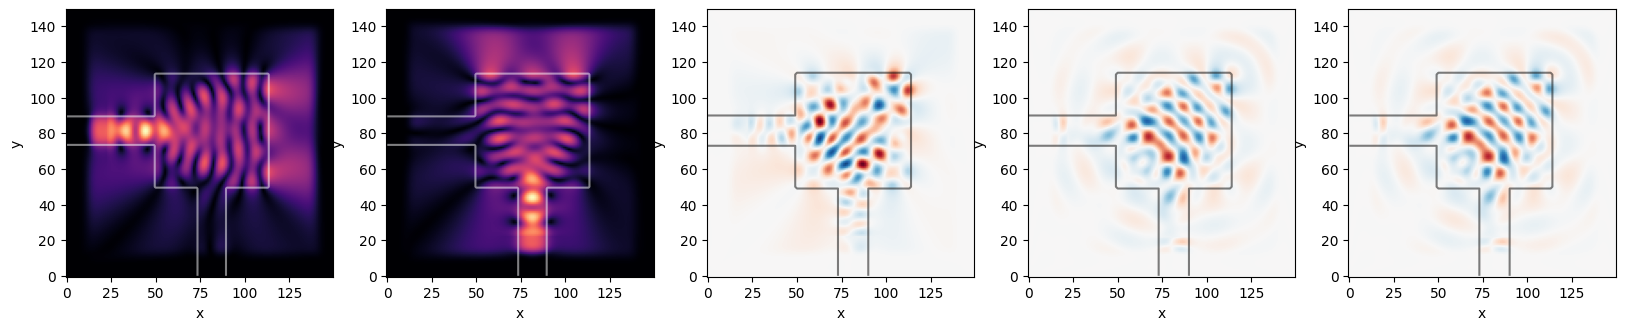

In [12]:
fig, ax = plt.subplots(1,5, figsize=(5*4,4))
viz.abs(ez_in, outline=model.density(np.asarray(design)), ax=ax[0]);
viz.abs(ez_out, outline=model.density(np.asarray(design)), ax=ax[1]);
viz.real(ez_in * np.conj(ez_out), outline=model.density(np.asarray(design)), ax=ax[2]);
viz.real(ez_in * ez_out, outline=model.density(np.asarray(design)), ax=ax[3]);
viz.real((Ez_source.squeeze() * Ez_probe.squeeze()).T, outline=model.density(np.asarray(design)), ax=ax[4]);

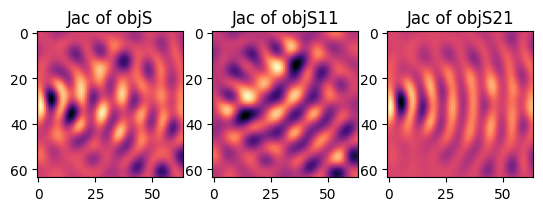

In [13]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(objective_jac_S(design).reshape(design.shape).T, cmap='magma');
ax[0].set_title('Jac of objS');
ax[1].imshow(objective_jac_S11(design).reshape(design.shape).T, cmap='magma');
ax[1].set_title('Jac of objS11');
ax[2].imshow(objective_jac_S21(design).reshape(design.shape).T, cmap='magma');
ax[2].set_title('Jac of objS21');
# ax[2].imshow(np.real(Ez.squeeze()).T);

# 0) Comparison of jacfwd / jacbwd / autograd.grad

In [14]:
jacfwd = jacobian(mode_overlap, mode='forward')(Ez, probe)
jacbwd = jacobian(mode_overlap, mode='reverse')(Ez, probe)
grad = autograd.grad(mode_overlap, argnum=0)(Ez, probe)

In [15]:
(jacfwd-jacbwd).max(), (jacfwd.flatten()-grad.flatten()).max()

((2.7755575615628914e-17-2.7755575615628914e-17j),
 (2.7755575615628914e-17-2.7755575615628914e-17j))

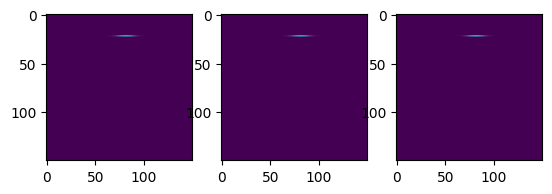

In [16]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(np.abs(jacfwd.reshape(Ez.squeeze().shape).T));
ax[1].imshow(np.abs(jacbwd.reshape(Ez.squeeze().shape).T));
ax[2].imshow(np.abs(grad.reshape(Ez.squeeze().shape).T));

In [17]:
src_in = model.ports[0].source_fdfd(_wavelengths_nm_to_omegas(u.resolve(params.wavelengths[0], 1*u.nm)),
                                    model.dl,#params.resolution,
                                    model.epsilon_r_bg()
                                   )

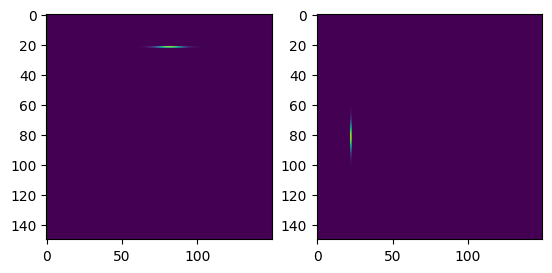

In [18]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(np.abs(jacfwd.reshape(Ez.squeeze().shape).T));
ax[1].imshow(np.abs(src_in.T));

array([[ 9.96665101e-05,  5.48470880e-05, -6.04800834e-05, ...,
        -3.87838018e-04, -4.60616839e-04, -3.86955736e-04],
       [ 5.49310166e-05,  4.50432374e-05, -2.64328912e-05, ...,
        -3.89137757e-04, -4.28588311e-04, -3.21465785e-04],
       [-6.03160357e-05, -2.63534465e-05, -2.51929314e-05, ...,
        -2.60671969e-04, -2.51889460e-04, -1.27359614e-04],
       ...,
       [-3.87961902e-04, -3.89484354e-04, -2.61276965e-04, ...,
         1.11022570e-03,  1.39814224e-03,  1.30005895e-03],
       [-4.61048942e-04, -4.29362841e-04, -2.53048908e-04, ...,
         1.39739649e-03,  1.77340011e-03,  1.68956918e-03],
       [-3.87633340e-04, -3.22551944e-04, -1.28896767e-04, ...,
         1.29877888e-03,  1.68898545e-03,  1.65153634e-03]])

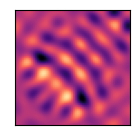

In [31]:
fig, ax = plt.subplots(1,figsize=(1.5,1.5))
viz.real(objective_jac_S11(design).reshape(design.shape).T, cmap='magma', ax=ax);
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

#### jacfwd / jacbwd / autograd.grad are close --> ALL GOODS !